Importing dependencies and loading the dataset

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope
import tqdm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Path of the file to read.
data_path = "countries-aggregated_csv.csv"
# Reading the file
data = pd.read_csv(data_path )


# Checking if CUDA is available
from numba import cuda
print(f'Cuda is available: {cuda.is_available()}')

Cuda is available: True


## Simple Multi-Linear Regression modeling part

### Note: Multi-Linear Regression is a poor model for this type of data and should not be used. The modelling is done for testing purposes only!

Making target y and input X for the XGBRegressor model and then splitting X and y into validation and training data.

In [16]:
# Features
features = ['Confirmed', 'Recovered']
X = data[features]

# Target
y = data['Deaths']

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=1)

# Preprocessing the training data.
# Normalizing the independent variables with StandardScaler
std_scaler = StandardScaler()
train_X = std_scaler.fit_transform(train_X)
val_X = std_scaler.transform(val_X)

Search space for hyperparameters.

In [13]:
# Define the search space
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 1)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 18, 1)),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    "reg_alpha": hp.uniform("reg_alpha", 0, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    "random_state": 1,
    "seed": 0,
    "max_bin": scope.int(hp.quniform("max_bin", 100, 1000, 1)),
    "booster": "gbtree",
}

Method that trains the model with the given parameters and calculates the MAE score and returns loss, status of the model.


In [14]:
def get_params(space):
    # Inputing the parameters
    model = XGBRegressor(**space)
    
    # Evaluation set
    eval_set = [(train_X, train_y), (val_X, val_y)]

    # Fit the model on the eval_set with early stopping
    model.fit(train_X, train_y, eval_set=eval_set, eval_metric="mae", early_stopping_rounds=50, verbose=False)

    # Get model predictions
    y_pred = model.predict(val_X)

    # Calculate MAE
    mae = mean_absolute_error(val_y, y_pred)
    print(f"MAE: {mae}")

    return {'loss': mae, 'status': STATUS_OK, 'model': model}

Bayesian optimization algorithm to find the most optimized parameters for the model.

In [15]:
trials = Trials()

best_params = fmin(fn=get_params,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=30,
                   trials=trials)

MAE: 146.09109136083902                               
MAE: 84.73853860129421                                                          
MAE: 77.43838327399514                                                          
MAE: 97.39075355475067                                                         
MAE: 488.92350552822666                                                        
MAE: 80.25820110007845                                                         
MAE: 97.96113248184805                                                         
MAE: 160.2403378058738                                                         
MAE: 472.0181773691171                                                         
MAE: 66.33735187525747                                                         
MAE: 112.57565502454374                                                         
MAE: 80.95158551074188                                                          
MAE: 94.63967556708155                                       

Inputing the algorithm results to define the XGBRegressor model.

In [16]:
best_model = trials.best_trial['result']['model']
print("The best hyperparameters are:")
print(best_params)
print("\nThe best optimized model:")
print(best_model)

The best hyperparameters are:
{'gamma': 4.1529192487015, 'learning_rate': 0.23356933588702536, 'max_bin': 345.0, 'max_depth': 14.0, 'min_child_weight': 0.0, 'n_estimators': 945.0, 'reg_alpha': 0.7955416040282769, 'reg_lambda': 0.21721771149866065}

The best optimized model:
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=4.1529192487015, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.23356933588702536, max_bin=345,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=0.0, missing=nan, monotone_constraints=None,
             n_estimators=945, n_jobs=None, num_parallel_tree=None

Testing how much better the optimized model is compared to the standard model.

In [17]:
# Testing the best model with the validation data
best_model.fit(train_X, train_y, eval_set=[(train_X, train_y), (val_X, val_y)], eval_metric=["mae"], early_stopping_rounds=50, verbose=False)
y_pred_best = best_model.predict(val_X)
mae = mean_absolute_error(val_y, y_pred_best)
print(f"MAE_Best_Model: {mae}")

# Testing the standard model with the validation data
standard_model = XGBRegressor()
standard_model.fit(train_X, train_y, eval_set=[(train_X, train_y), (val_X, val_y)], eval_metric=["mae"], early_stopping_rounds=50, verbose=False)
y_pred_std = standard_model.predict(val_X)
mae_std = mean_absolute_error(val_y, y_pred_std)
print(f"MAE_Standard_Model: {mae_std}")
print(f"MAE_Difference: {mae_std - mae}")

MAE_Best_Model: 65.02643490380201
MAE_Standard_Model: 488.9359605975645
MAE_Difference: 423.9095256937625


Checking if the model underfits or overfits.

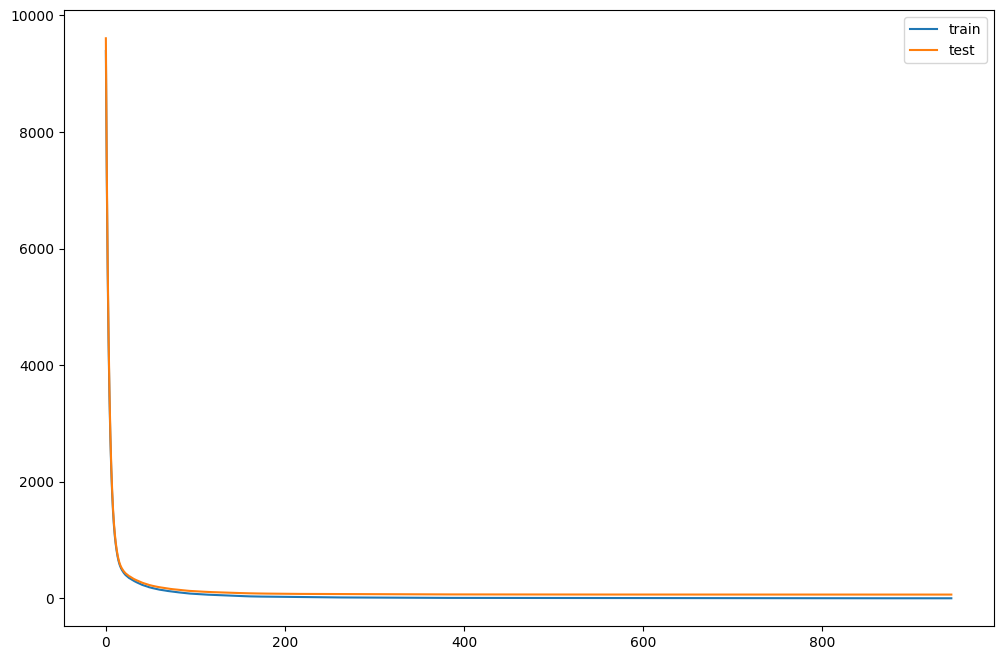

In [26]:
results = best_model.evals_result()

plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['mae'], label='train')
plt.plot(results['validation_1']['mae'], label='test')
plt.xlabel('Iteration')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

The validation and training losses seem to decrease close to zero, so the model is learning and not underfitting on both training and test cases. The losses also do not start to increase at any point, so the model does not seem to be overfitting on both training and test cases. Both plots are almost identical, so the model seems to be predicting unknown target cases quite well. We could try using different linear regression models, but XGBoost seems to do a great job with HyperOpt optimisation, so this is not necessary.

The problem with this type of modelling is that it forces all countries to fit into a simple linear regression model, which does not give us realistic or useful information because we cannot get meaningful continuous predictions for certain countries. Instead, we should try to classify the countries with the features 'confirmed', 'recovered' and 'deaths' and perhaps add some other features to the dataset that might give us more information. On the other hand, we could try to use clustering and create new classes to which each country belongs.

## Classification part

Feature engineering

Accuracy of the model is: 0.407021.


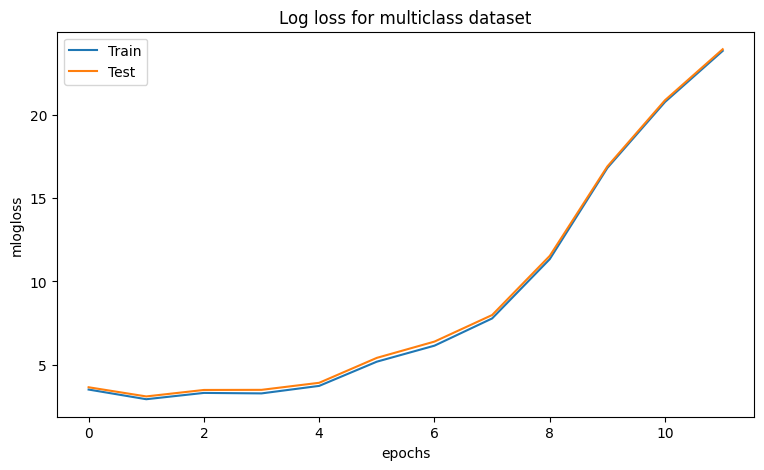

In [19]:
# Copying the data
modified_data = data.copy()

# Features
features = ['Confirmed', 'Recovered', 'Deaths']
target = 'Country'

def train_test_generator(features, target, data, lr=None, stratified=False):
    """
    The function sets features and target and then splits the data into training data and testing data. If learning
    rate is not given, then model uses the seeded learning rate. If stratified is set to True, then the data in the
    dataframe is stratified.
    """

    # Features
    X = data[features].copy()

    # Target
    y = data[target].copy()

    # Split into validation and training data
    if stratified:
        train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    else:
        train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=42)
    

    # Preprocessing
    std_scaler = StandardScaler()
    train_X = std_scaler.fit_transform(train_X)
    val_X = std_scaler.transform(val_X)

    # Label encoding to change the target to numerical, so model can classify classes based on numbers
    label_encoder = LabelEncoder()
    train_y = label_encoder.fit_transform(train_y)
    val_y = label_encoder.transform(val_y)

    # Testing the model and getting the accuracy
    test_model(train_X, train_y, val_X, val_y, lr)

    return None


# Testing function
def test_model(train_X, train_y, val_X, val_y, lr):
    """
    The function trains the XGB Classification model, prints the accuracy of the model and plots
    the performance of the model. The model takes as inputs the training and validation data and learning rate.
    """

    model = XGBClassifier(
        device='cuda',
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        objective='multi:softmax',
        learning_rate=lr,
        num_class=195,
        early_stopping_rounds=10,
        eval_metric=['merror', 'mlogloss'],
        seed=42
        )
    
    model.fit(train_X, train_y, eval_set=[(train_X, train_y), (val_X, val_y)], verbose=False)
    y_pred = model.predict(val_X)
    accuracy = accuracy_score(y_pred, val_y)
    print(f'Accuracy of the model is: {accuracy:4f}.')

    # Plotting the performance of the model
    results = model.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)

    _, ax = plt.subplots(figsize = (9,5))
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
    ax.legend()
    plt.xlabel('epochs')
    plt.ylabel('mlogloss')
    plt.title('Log loss for multiclass dataset')
    plt.show()

    return None

# Testing the model to see what is the starting accuracy
train_test_generator(features, target, modified_data)

The standard accuracy of the model is around **0.4**, which is expected because there are only a few features and 195 classes, which makes it hard for the model to classify correctly. We can also see from the performance plot, that the model starts to **overfit** after **3** epochs, which tells us that the initial learning rate is probably too high. Let's lower it and see if it helps.

Accuracy of the model is: 0.658291.


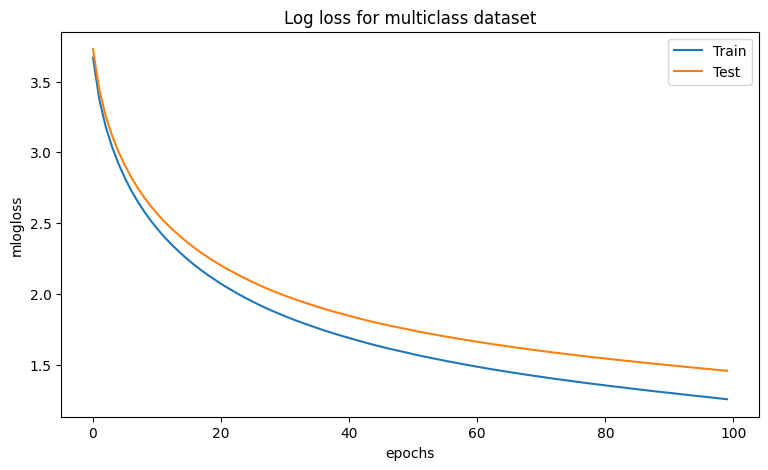

In [20]:
train_test_generator(features, target, modified_data, lr=0.1)

The accuracy of the model improved a lot from **0.4** to around **0.66** accuracy after we set the initial learning rate to **0.1**. The data might have unbalanced data classes, so we can stratify them and see if it helps the model.

Accuracy of the model is: 0.656365.


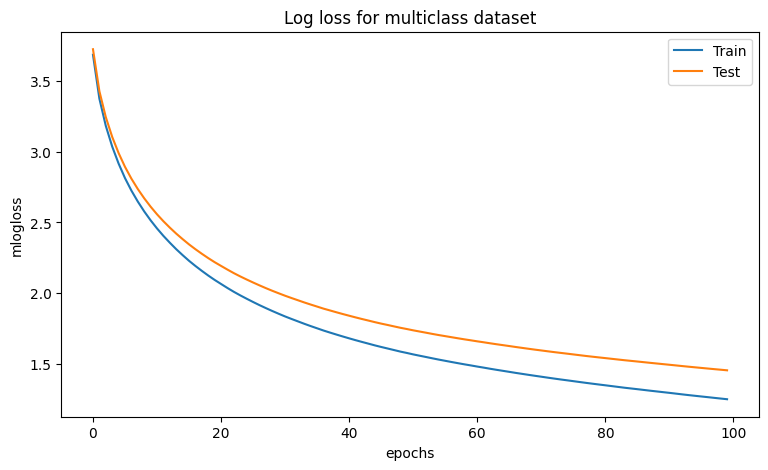

In [21]:
train_test_generator(features, target, modified_data, 0.1, True)

We can see that the model did not improve, so stratifying is not needed for our model. The model seems to work well with the training data, but we can see from the testing performance, that the model underfits a little bit. Let's see if adding more features will improve the accuracy of the model and help with the underfitting.

Features: ['Confirmed', 'Recovered', 'Deaths', 'Death_Rate']
Accuracy of the model is: 0.735644.


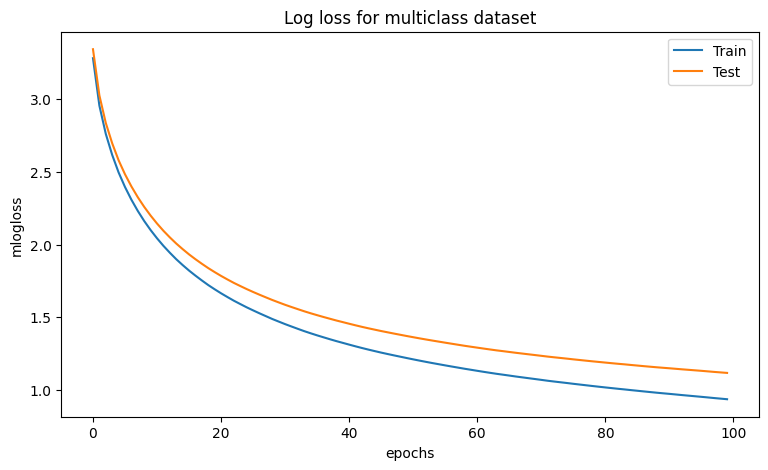



Features: ['Confirmed', 'Recovered', 'Deaths', 'Recovery_Rate']
Accuracy of the model is: 0.718638.


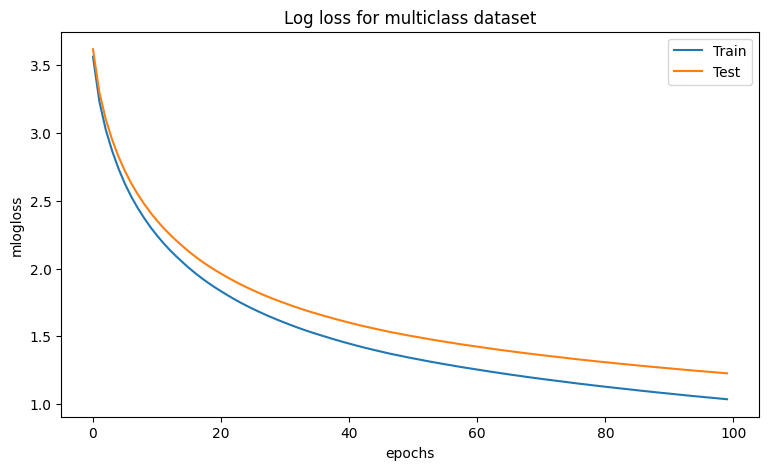



Features: ['Confirmed', 'Recovered', 'Deaths', 'Death_Recovery_Ratio']
Accuracy of the model is: 0.716271.


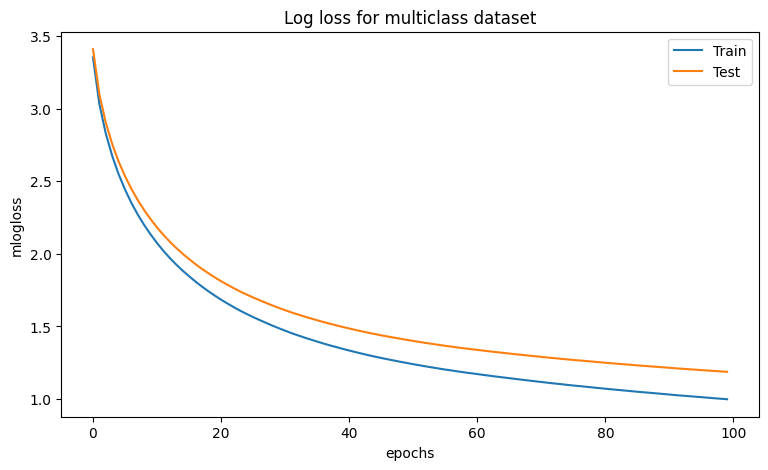



Features: ['Confirmed', 'Recovered', 'Deaths', 'Death_Rate', 'Recovery_Rate']
Accuracy of the model is: 0.785086.


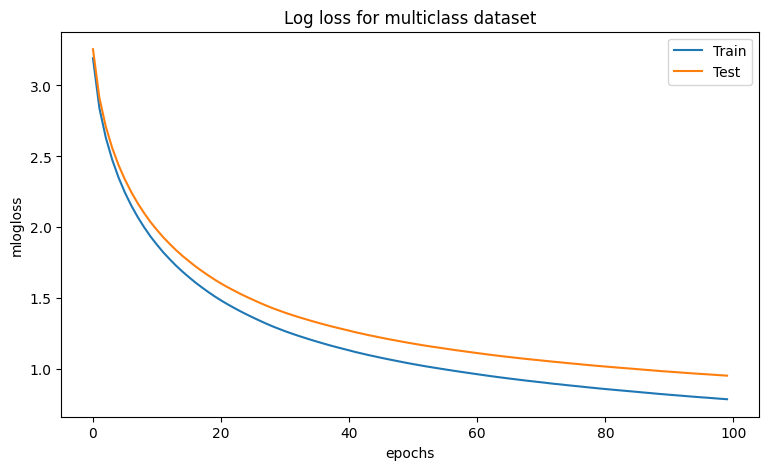



Features: ['Confirmed', 'Recovered', 'Deaths', 'Death_Rate', 'Death_Recovery_Ratio']
Accuracy of the model is: 0.774042.


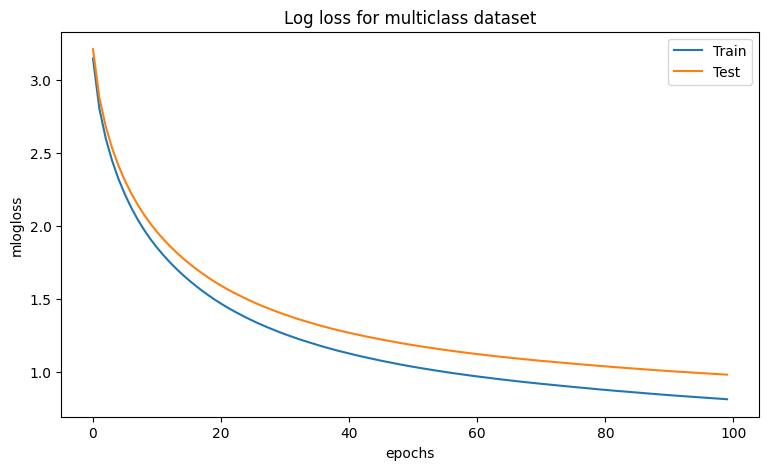



Features: ['Confirmed', 'Recovered', 'Deaths', 'Recovery_Rate', 'Death_Recovery_Ratio']
Accuracy of the model is: 0.760910.


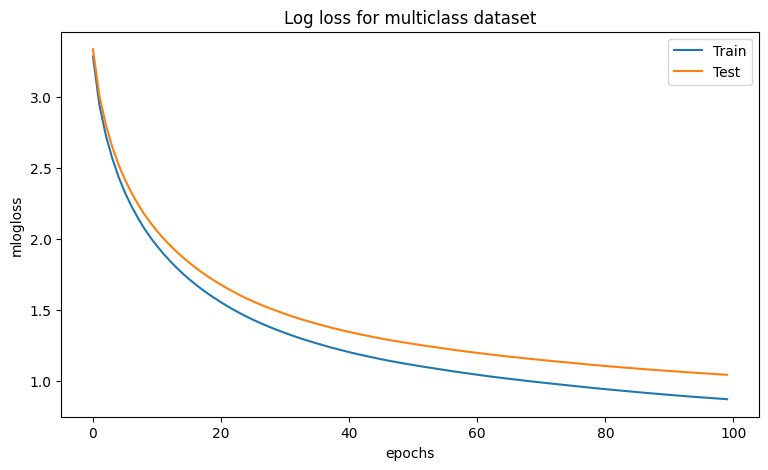



Features: ['Confirmed', 'Recovered', 'Deaths', 'Death_Rate', 'Recovery_Rate', 'Death_Recovery_Ratio']
Accuracy of the model is: 0.792047.


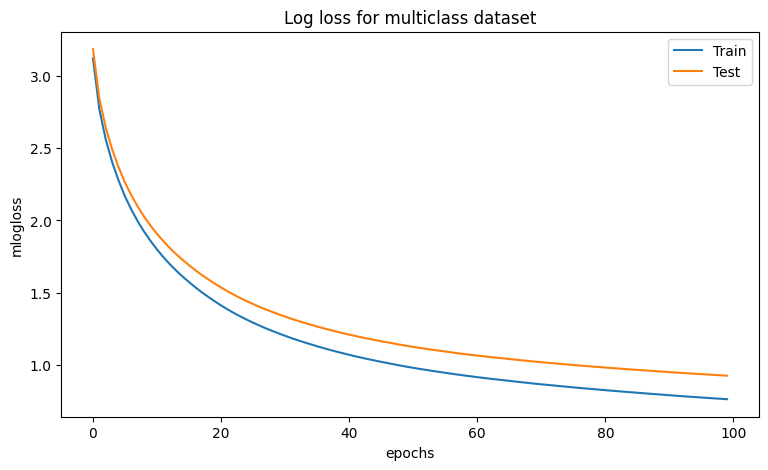

In [22]:
def add_feature(data, feature1, feature2, new_feature):
    """
    Function to add new features to the dataset. The function takes Pandas Dataframe, two known features and
    a new feature name as inputs and adds the new feature to the dataframe. If rows contain NaN values, then those
    values are replaced with mean of the feature values. If rows contain +/- inf values, then those values are
    replaced with 0.

    data = Pandas Dataframe\n
    feature1 = The first known feature\n
    feature2 = The second known feature\n
    new_feature = The new feature name as string
    """
    data[new_feature] = (data[feature1]/data[feature2])*100
    data[new_feature] = data[new_feature].fillna(data[new_feature].mean())
    data[new_feature] = data[new_feature].replace([float('inf')], 0)
    return data

# Adding new features
features_to_add = [
    ('Deaths', 'Confirmed', 'Death_Rate'),
    ('Recovered', 'Confirmed', 'Recovery_Rate'),
    ('Deaths', 'Recovered', 'Death_Recovery_Ratio')    
]

# Copying the original data to a new variable
mod_data = data.copy()

for feature1, feature2, new_feature in features_to_add:
    mod_data = add_feature(mod_data, feature1, feature2, new_feature)

# Feature lists
new_features = ['Death_Rate', 'Recovery_Rate', 'Death_Recovery_Ratio']
base_features = ['Confirmed', 'Recovered', 'Deaths']

from itertools import combinations
# Feature combinations
features = [base_features + list(comb) for i in range(1, len(new_features)+1) for comb in combinations(new_features, i)]

# Testing the model with the new feature combinations
for feature in features:
    print(f"Features: {feature}")
    train_test_generator(feature, target, mod_data, 0.1)
    print("\n")

We can see that the accuracy of the model improved when we used **Death rate**, **Recovery rate** and **Death Recovery rate** as features in the model for about **15 %**, so seems like together they can give some new information like we anticipated in the data analysis part.

Next, we can try to improve the model with hyperparameter tuning. We will use HyperOpt's TPE algorithm and try to improve the accuracy of the model and fix the underfitting. Let's start with defining **hyperparameter space** dictionary, **get_parameters** function and **loss_plot** function.

In [2]:
# Defining the search space.
space = {
    'device': 'cuda',
    'tree_method':'hist',
    'objective': 'multi:softmax',
    'num_class': 195,
    'seed': 42,
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 100)),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
}

def get_parameters(space):
    """
    The function sets the XGBClassification model training and returns negative accuracy, status
    and the model. The function takes the parameter space of the XGB Model as input
    """


    # Inputing the parameters
    model = XGBClassifier(**space)
    
    # Evaluation set
    eval_set = [(train_X, train_y), (val_X, val_y)]

    # Fit the model on the eval_set with early stopping
    model.fit(train_X, train_y, eval_set=eval_set, eval_metric="mlogloss", early_stopping_rounds=10, verbose=False)

    # Get model predictions
    y_pred = model.predict(val_X)

    # Calculate accuracy
    accuracy = accuracy_score(y_pred, val_y)
    print(f"Accuracy: {accuracy}")

    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

def plot_results(results):
    """
    The function plots the mlogloss performance of the model
    """

    plt.plot(results["validation_0"]["mlogloss"], label="Train")
    plt.plot(results["validation_1"]["mlogloss"], label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("mlogloss")
    plt.title("mlogloss performance of the model")
    plt.legend()
    plt.show()

### Optimization

Adding **Death rate**, **Recovery rate** and **Death Recovery rate** to the features and then scaling the features and encoding the target classes.


In [41]:
featured_data = data.copy()
featured_data = add_feature(featured_data, 'Confirmed', 'Deaths', 'Death_Rate')
featured_data = add_feature(featured_data, 'Confirmed', 'Recovered', 'Recovery_Rate')
faetured_data = add_feature(featured_data, 'Deaths', 'Recovered', 'Death_Recovery_Rate')

features = ['Confirmed', 'Recovered', 'Deaths', 'Death_Rate', 'Recovery_Rate', 'Death_Recovery_Rate']
target = 'Country'

X = featured_data[features].copy()
y = featured_data[target].copy()

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=1)

std_scaler = StandardScaler()
train_X = std_scaler.fit_transform(train_X)
val_X = std_scaler.transform(val_X)

lbl_encoder = LabelEncoder()
train_y = lbl_encoder.fit_transform(train_y)
val_y = lbl_encoder.transform(val_y)

Running the optimization algorithm, so that we can possibly find more optimized hyperparameters for the model.

Accuracy: 0.8269877729055011                         
Accuracy: 0.8268485649984919                                                     
Accuracy: 0.8269181689519964                                                     
Accuracy: 0.8203985986404028                                                     
Accuracy: 0.8262917333704555                                                     
100%|██████████| 5/5 [26:56<00:00, 323.20s/trial, best loss: -0.8269877729055011]
Optimized model:
{'learning_rate': 0.07084084401769969, 'max_depth': 9.0, 'n_estimators': 700.0}


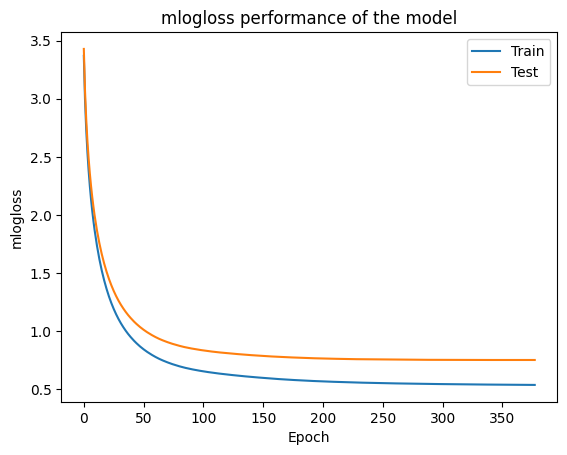

In [25]:
trials = Trials()

optimized_parameters = fmin(
    fn = get_parameters,
    space = space,
    algo = tpe.suggest,
    max_evals = 5,
    trials = trials
    )

optimized_model = trials.best_trial['result']['model']
print(f"Optimized model:\n{optimized_parameters}")

results = optimized_model.evals_result()
plot_results(results)

Seems like the optimization algorithm could optimize the model a little bit, but the model still seems to struggle with the test data. Let's add some more hyperparameters and see if the model can be improved by optimization.

Accuracy: 0.8316744391081413                         
Accuracy: 0.8312104127514442                                                     
Accuracy: 0.7846685691747292                                                     
Accuracy: 0.8269413702698313                                                     
Accuracy: 0.8194705459270086                                                     
100%|██████████| 5/5 [20:46<00:00, 249.29s/trial, best loss: -0.8316744391081413]
Optimized parameters:
{'learning_rate': 0.14325718263101425, 'max_bin': 948.0, 'max_depth': 6.0, 'n_estimators': 300.0, 'reg_alpha': 0.13818022806757013, 'reg_lambda': 0.8004941486549634}


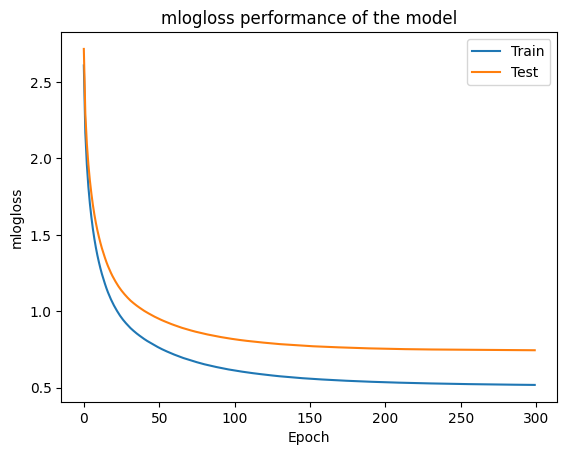

In [27]:
space = {
    'device': 'cuda',
    'tree_method':'hist',
    "booster": "gbtree",
    'objective': 'multi:softmax',
    'num_class': 195,
    'seed': 42,
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 100)),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    "max_bin": scope.int(hp.quniform("max_bin", 100, 1000, 1)),
    "reg_alpha": hp.uniform("reg_alpha", 0, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
}

trials = Trials()

optimized_parameters = fmin(
    fn = get_parameters,
    space = space,
    algo = tpe.suggest,
    max_evals = 5,
    trials = trials
    )

optimized_model = trials.best_trial['result']['model']
print(f"Optimized parameters:\n{optimized_parameters}")

results = optimized_model.evals_result()
plot_results(results)


We could only barely improve the accuracy of the model by adding more hyperparameters and the model still underfits when using the test data. There might be just too much noise in the data, which makes it hard for the model to learn. There might be some countries that have zero values in their rows, which makes the model guess the label. Also when we are adding features we are setting the row data to the certain values, when there is zero division, so we could just drop those rows from the data and check if that helps the model performance.

In [7]:
def add_features_modified(data, feature_1, feature_2, new_feature):
    """
    The function takes Pandas dataframe, two known features and a new feature name as input and adds the new
    new feature to the data. If the data rows contain NaN or +/- inf values, then those rows
    are dropped from the data to reduce the noise from the data.

    data = Pandas dataframe\n
    feature_1 = The first known feature\n
    feature_2 = The second known feature\n
    new_feature = The new feature name
    """
    data[new_feature] = (data[feature_1] / data[feature_2]) * 100
    data.replace(float('inf'), np.nan, inplace = True)
    data.dropna(inplace=True)
    return data
    

featured_data = data.copy()
featured_data = add_features_modified(featured_data, 'Confirmed', 'Deaths', 'Death_Rate')
featured_data = add_features_modified(featured_data, 'Confirmed', 'Recovered', 'Recovery_Rate')
faetured_data = add_features_modified(featured_data, 'Deaths', 'Recovered', 'Death_Recovery_Rate')

features = ['Confirmed', 'Recovered', 'Deaths', 'Death_Rate', 'Recovery_Rate', 'Death_Recovery_Rate']
target = 'Country'

X = featured_data[features].copy()
y = featured_data[target].copy()

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=1)

std_scaler = StandardScaler()
train_X = std_scaler.fit_transform(train_X)
val_X = std_scaler.transform(val_X)

lbl_encoder = LabelEncoder()
train_y = lbl_encoder.fit_transform(train_y)
val_y = lbl_encoder.transform(val_y)

Let's check first how many classes there are after we remove the classes with missing data and update hyperparameter space then.

In [19]:
nCountries = featured_data['Country'].nunique()
print(f'The number of unique countries in the dataset: {nCountries}')

The number of unique countries in the dataset: 185


Accuracy: 0.9230232016761077                         
Accuracy: 0.9291146116241173                                                     
Accuracy: 0.930511368045317                                                      
Accuracy: 0.9288818188872507                                                     
Accuracy: 0.9285326297819508                                                    
100%|██████████| 5/5 [17:57<00:00, 215.53s/trial, best loss: -0.930511368045317]
Optimized parameters:
{'max_bin': 208.0, 'max_depth': 8.0, 'n_estimators': 300.0, 'reg_alpha': 0.5180493597086517, 'reg_lambda': 0.8852950468277969}


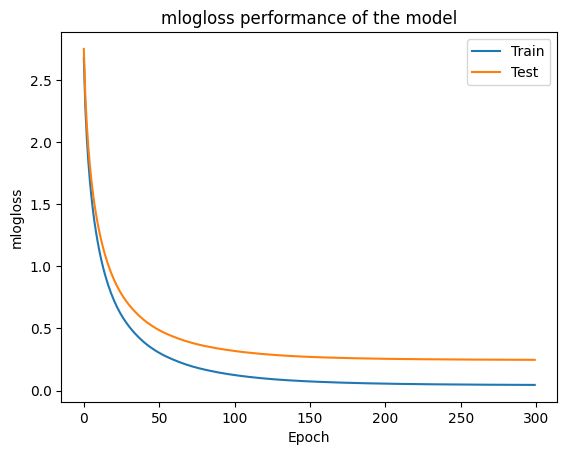

In [9]:
space = {
    'device': 'cuda',
    'tree_method':'hist',
    "booster": "gbtree",
    'objective': 'multi:softmax',
    'num_class': 185,
    'seed': 42,
    'learning_rate': 0.1,
    'gamma': 0,
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 100)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 10, 1)),
    "max_bin": scope.int(hp.quniform("max_bin", 100, 1000, 1)),
    "reg_alpha": hp.uniform("reg_alpha", 0, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
}

trials = Trials()

optimized_parameters = fmin(
    fn = get_parameters,
    space = space,
    algo = tpe.suggest,
    max_evals = 5,
    trials = trials
    )

optimized_model = trials.best_trial['result']['model']
print(f"Optimized parameters:\n{optimized_parameters}")

results = optimized_model.evals_result()
plot_results(results)

Seems like we could eliminate some noise from the training data, so training and test mlogloss result and the accuracy of the model got better for almost **10 %**, but the model still underfits to the test data. We could probably reduce underfitting by adding more features to the model, which would help model to identify certain classes more easily.

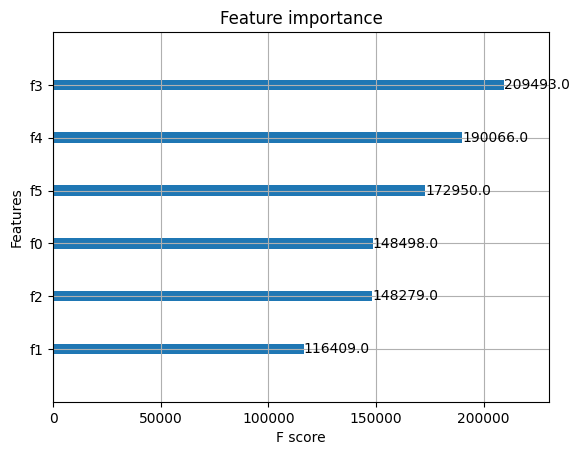

In [10]:
plot_importance(optimized_model)
plt.show()

As we can see from the feature importance plot, that the new added features dominate the base features in importance for the model. Let's see if we can add more features that can improve the model performance. We will use sklearn's PolynomialFeatures library, which makes polynomial features out of the normal features, which might help the model to learn better and help with the underfitting problem.

In [11]:
X = featured_data[features].copy()
y = featured_data[target].copy()

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

train_X, val_X, train_y, val_y = train_test_split(X_poly, y, test_size=0.3, random_state=1)

train_X = std_scaler.fit_transform(train_X)
val_X = std_scaler.transform(val_X)

train_y = lbl_encoder.fit_transform(train_y)
val_y = lbl_encoder.transform(val_y)

Accuracy: 0.9390859005199038                         
Accuracy: 0.9130131139908435                                                     
Accuracy: 0.9382711259408707                                                     
Accuracy: 0.9418018157833475                                                     
Accuracy: 0.9399782726778925                                                     
100%|██████████| 5/5 [17:32<00:00, 210.53s/trial, best loss: -0.9418018157833475]
Optimized parameters:
{'max_bin': 963.0, 'max_depth': 10.0, 'n_estimators': 200.0, 'reg_alpha': 0.18949448579092476, 'reg_lambda': 0.6310540811876492}


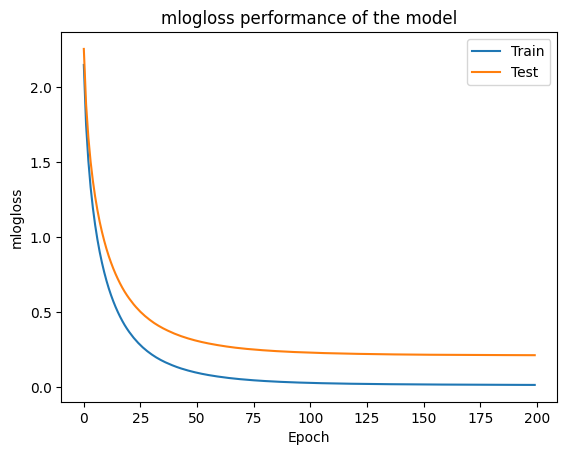

In [12]:
space = {
    'device': 'cuda',
    'tree_method':'hist',
    "booster": "gbtree",
    'objective': 'multi:softmax',
    'num_class': 185,
    'seed': 42,
    'learning_rate': 0.1,
    'gamma': 0,
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 100)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 10, 1)),
    "max_bin": scope.int(hp.quniform("max_bin", 100, 1000, 1)),
    "reg_alpha": hp.uniform("reg_alpha", 0, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
}

trials = Trials()

optimized_parameters = fmin(
    fn = get_parameters,
    space = space,
    algo = tpe.suggest,
    max_evals = 5,
    trials = trials
    )

optimized_model = trials.best_trial['result']['model']
print(f"Optimized parameters:\n{optimized_parameters}")

results = optimized_model.evals_result()
plot_results(results)

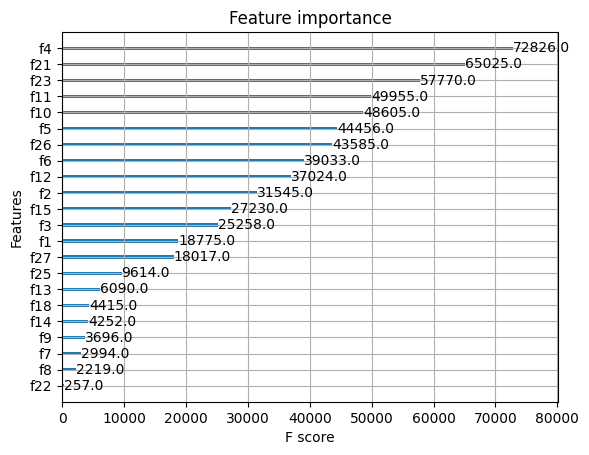

In [14]:
plot_importance(optimized_model)
plt.show()

We could improve the accuracy of the model by one percent and reduce the mlogloss a little bit by adding the **polynomial features**, but the model still suffers from the underfitting in the test data. Let's test if increasing the degree of polynomial features affect the model performance. Adding more than three degrees to the polynomial features is probably an overkill and makes the model too complex and overfit.

Accuracy: 0.939047101730426                          
Accuracy: 0.9384651198882595                                                    
Accuracy: 0.9443237370994025                                                    
Accuracy: 0.9387367114146039                                                     
Accuracy: 0.9438969504151471                                                     
100%|██████████| 5/5 [24:06<00:00, 289.40s/trial, best loss: -0.9443237370994025]
Optimized parameters:
{'max_bin': 118.0, 'max_depth': 6.0, 'n_estimators': 500.0, 'reg_alpha': 0.1568258150316153, 'reg_lambda': 0.8070531056972998}


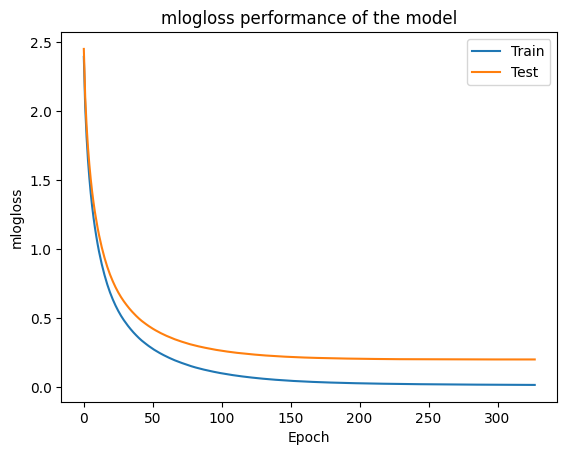

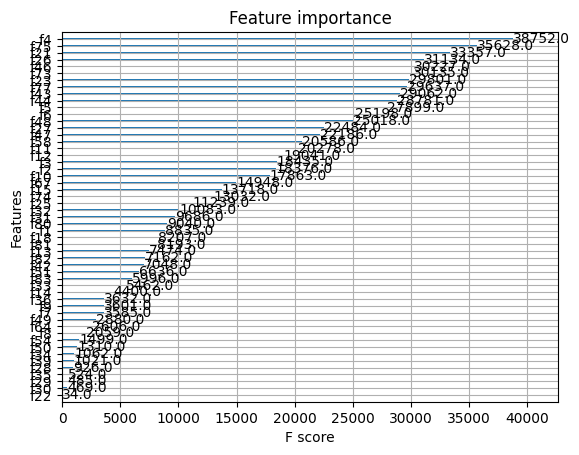

In [16]:
X = featured_data[features].copy()
y = featured_data[target].copy()

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

train_X, val_X, train_y, val_y = train_test_split(X_poly, y, test_size=0.3, random_state=1)

train_X = std_scaler.fit_transform(train_X)
val_X = std_scaler.transform(val_X)

train_y = lbl_encoder.fit_transform(train_y)
val_y = lbl_encoder.transform(val_y)

space = {
    'device': 'cuda',
    'tree_method':'hist',
    "booster": "gbtree",
    'objective': 'multi:softmax',
    'num_class': 185,
    'seed': 42,
    'learning_rate': 0.1,
    'gamma': 0,
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 100)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 10, 1)),
    "max_bin": scope.int(hp.quniform("max_bin", 100, 1000, 1)),
    "reg_alpha": hp.uniform("reg_alpha", 0, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
}

trials = Trials()

optimized_parameters = fmin(
    fn = get_parameters,
    space = space,
    algo = tpe.suggest,
    max_evals = 5,
    trials = trials
    )

optimized_model = trials.best_trial['result']['model']
print(f"Optimized parameters:\n{optimized_parameters}")

results = optimized_model.evals_result()
plot_results(results)
plot_importance(optimized_model)
plt.show()

The accuracy of the model improved just a little bit with higher degree polynomials and the model complexity increased a lot which is not ideal, so probably **2 degrees** is enough. Seems like we need to figure out better ways to increase the performance of the model. In the data analysis part log features seemed to be the most important features, so we could add log features to the dataset and see if they help with the classification performance.

In [17]:
def add_log_features(data, feature):
    data['Log_' + feature] = np.log(data[feature])
    data['Log_' + feature].replace([-np.inf, np.inf], np.nan, inplace = True)
    data['Log_' + feature].dropna(inplace = True)
    return data

featured_data = add_log_features(featured_data, 'Confirmed')
featured_data = add_log_features(featured_data, 'Deaths')
featured_data = add_log_features(featured_data, 'Recovered')
featured_data = add_log_features(featured_data, 'Death_Rate')
featured_data = add_log_features(featured_data, 'Recovery_Rate')
featured_data = add_log_features(featured_data, 'Death_Recovery_Rate')

featured_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85912 entries, 61 to 143495
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     85912 non-null  object 
 1   Country                  85912 non-null  object 
 2   Confirmed                85912 non-null  int64  
 3   Recovered                85912 non-null  int64  
 4   Deaths                   85912 non-null  int64  
 5   Death_Rate               85912 non-null  float64
 6   Recovery_Rate            85912 non-null  float64
 7   Death_Recovery_Rate      85912 non-null  float64
 8   Log_Confirmed            85912 non-null  float64
 9   Log_Deaths               85912 non-null  float64
 10  Log_Recovered            85912 non-null  float64
 11  Log_Death_Rate           85912 non-null  float64
 12  Log_Recovery_Rate        85912 non-null  float64
 13  Log_Death_Recovery_Rate  85912 non-null  float64
dtypes: float64(9), int64(3), 

Accuracy: 0.9398618763094592                         
Accuracy: 0.9411422363622255                                                     
Accuracy: 0.9363311864669822                                                     
Accuracy: 0.9416466206254365                                                     
Accuracy: 0.9391634980988594                                                     
100%|██████████| 5/5 [23:59<00:00, 287.91s/trial, best loss: -0.9416466206254365]
Optimized parameters:
{'max_bin': 917.0, 'max_depth': 6.0, 'n_estimators': 900.0, 'reg_alpha': 0.30830199819413984, 'reg_lambda': 0.44357373290112556}


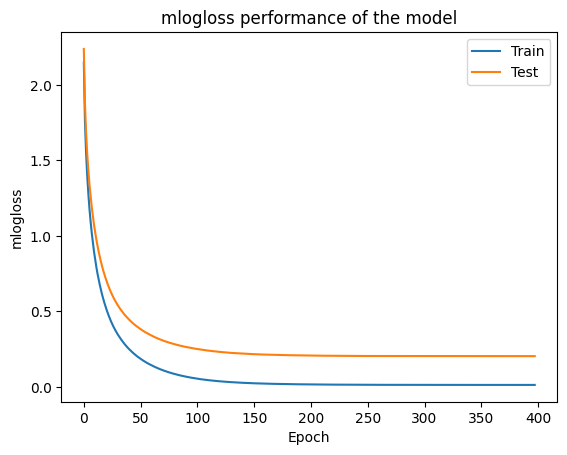

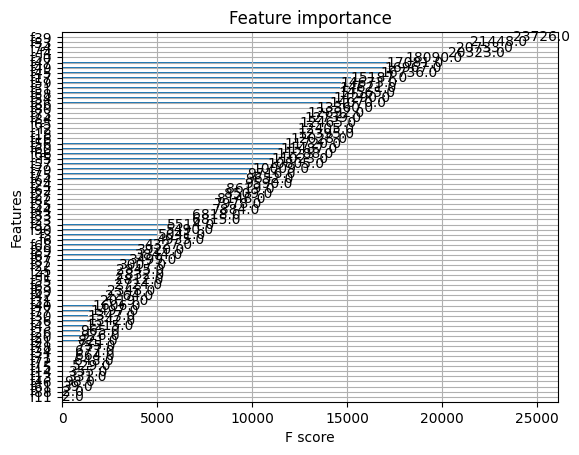

In [21]:
features = ['Confirmed', 'Recovered', 'Deaths', 'Death_Rate', 'Recovery_Rate', 'Death_Recovery_Rate',
            'Log_Confirmed', 'Log_Deaths', 'Log_Recovered', 'Log_Death_Rate', 'Log_Recovery_Rate',
            'Log_Death_Recovery_Rate'
            ]
target = 'Country'

X = featured_data[features].copy()
y = featured_data[target].copy()

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

train_X, val_X, train_y, val_y = train_test_split(X_poly, y, test_size=0.3, random_state=1)

train_X = std_scaler.fit_transform(train_X)
val_X = std_scaler.transform(val_X)

train_y = lbl_encoder.fit_transform(train_y)
val_y = lbl_encoder.transform(val_y)

space = {
    'device': 'cuda',
    'tree_method':'hist',
    "booster": "gbtree",
    'objective': 'multi:softmax',
    'num_class': 185,
    'seed': 42,
    'learning_rate': 0.1,
    'gamma': 0,
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 100)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 10, 1)),
    "max_bin": scope.int(hp.quniform("max_bin", 100, 1000, 1)),
    "reg_alpha": hp.uniform("reg_alpha", 0, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
}

trials = Trials()

optimized_parameters = fmin(
    fn = get_parameters,
    space = space,
    algo = tpe.suggest,
    max_evals = 5,
    trials = trials
    )

optimized_model = trials.best_trial['result']['model']
print(f"Optimized parameters:\n{optimized_parameters}")

results = optimized_model.evals_result()
plot_results(results)
plot_importance(optimized_model)
plt.show()

In [29]:
features = ['Confirmed', 'Recovered', 'Deaths', 'Death_Rate', 'Recovery_Rate', 'Death_Recovery_Rate',
            'Log_Confirmed', 'Log_Deaths', 'Log_Recovered', 'Log_Death_Rate', 'Log_Recovery_Rate',
            'Log_Death_Recovery_Rate'
            ]
target = 'Country'

X = featured_data[features].copy()

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Scaling the features for PCA
X_poly_scaled = std_scaler.fit_transform(X_poly)

# Performing the PCA on the modified data.
transformer = PCA(n_components=None)
X_transformed = transformer.fit_transform(X_poly_scaled)

# Extracting the loadings
loadings = pd.DataFrame(transformer.components_.T, columns=[f'PC{i+1}' for i in range(transformer.n_components_)], index=poly.get_feature_names_out(features))

# Calculating the importance of each feature by summing the absolute values of the loadings across all principal components.
feature_importance = loadings.abs().sum(axis=1)

# Rank the features by importance
ranked_features = feature_importance.sort_values(ascending=False)

# Drop the least important features (e.g., keep top 20 features)
top_features = ranked_features.head(20).index

# Transform the original data using polynomial features and scaling
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(features))
print(X_poly_df.head())

     1  Confirmed  Recovered  Deaths  Death_Rate  Recovery_Rate  \
0  1.0       40.0        1.0     1.0      4000.0         4000.0   
1  1.0       42.0        1.0     1.0      4200.0         4200.0   
2  1.0       74.0        2.0     1.0      7400.0         3700.0   
3  1.0       80.0        2.0     2.0      4000.0         4000.0   
4  1.0       91.0        2.0     2.0      4550.0         4550.0   

   Death_Recovery_Rate  Log_Confirmed  Log_Deaths  Log_Recovered  ...  \
0                100.0       3.688879    0.000000       0.000000  ...   
1                100.0       3.737670    0.000000       0.000000  ...   
2                 50.0       4.304065    0.000000       0.693147  ...   
3                100.0       4.382027    0.693147       0.693147  ...   
4                100.0       4.510860    0.693147       0.693147  ...   

   Log_Recovered^2  Log_Recovered Log_Death_Rate  \
0         0.000000                      0.000000   
1         0.000000                      0.000000   
2 

Accuracy: 0.9435477613098471                         
Accuracy: 0.9425001939939474                                                     
Accuracy: 0.9411810351517033                                                     
Accuracy: 0.9446729262047024                                                     
Accuracy: 0.9430433770466361                                                     
100%|██████████| 5/5 [33:10<00:00, 398.09s/trial, best loss: -0.9446729262047024]
Optimized parameters:
{'max_bin': 405.0, 'max_depth': 8.0, 'n_estimators': 1000.0, 'reg_alpha': 0.1306419651482157, 'reg_lambda': 0.9766416218766851}


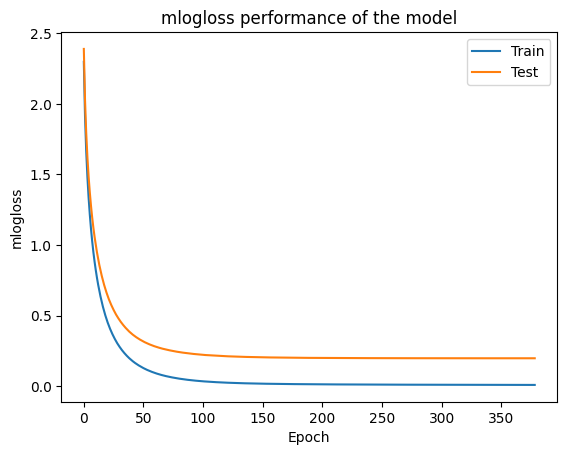

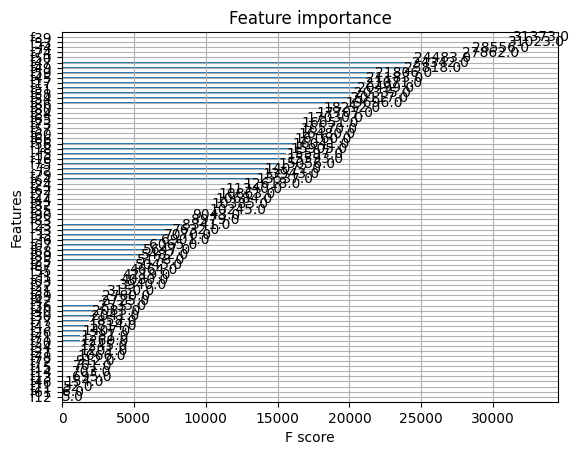

In [30]:
y = featured_data[target].copy()

train_X, val_X, train_y, val_y = train_test_split(X_poly_df, y, test_size=0.3, random_state=1)

train_X = std_scaler.fit_transform(train_X)
val_X = std_scaler.transform(val_X)

train_y = lbl_encoder.fit_transform(train_y)
val_y = lbl_encoder.transform(val_y)

trials = Trials()

optimized_parameters = fmin(
    fn = get_parameters,
    space = space,
    algo = tpe.suggest,
    max_evals = 5,
    trials = trials
    )

optimized_model = trials.best_trial['result']['model']
print(f"Optimized parameters:\n{optimized_parameters}")

results = optimized_model.evals_result()
plot_results(results)
plot_importance(optimized_model)
plt.show()

## Change log

| Date | Version | Change Description |
| --- | --- | --- |
| 29.5.2024 | 1.0.1 | Removed variance plot. Added more descriptions. Fixed preprocessing and removed country from the feature list. Added LabelEncoder |
| 30.5.2024 | 1.0.2 | Classification part added. Feature engineering testing. Simplified variable names. Added helper functions for classification. |
| 24.7.2024 | 1.0.3 | Added stratify option and added HyperOpt optimization |
| 4.8.2024 | 1.0.4 | Added polynomial features and optimized the model |